## Dataset Creation 

In [1]:
import numpy as np
import torch 

seed = 42 

np.random.seed(seed)
torch.manual_seed(seed)

rng = np.random.RandomState(seed)
def true_function(x):
    return np.sin(2 * np.pi * x)

X_test = np.linspace(0, 1, 200).reshape(-1, 1)
y_true = true_function(X_test)

X_train = np.sort(rng.rand(10, 1))
y_train = true_function(X_train).ravel() 

## Plotting

In [2]:
import matplotlib.pyplot as plt

def plot_uncertainty_results(mean, lower, upper, model_name): 
    plt.figure(figsize=(10, 6))
    plt.plot(X_test, y_true, 'g--', label="True Function")
    plt.scatter(X_train, y_train, color='black', label="Training data", alpha=0.6)
    plt.plot(X_test, mean, label="Predicted Mean", color="blue")
    plt.fill_between(X_test.ravel(), lower, upper, alpha=0.3, color="blue", label = "Uncertainty Interval")
    plt.legend()
    plt.title(f"{model_name} Uncertainty Test")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

## MC Dropout

[Logger-10200] epoch=0, train_loss=0.5464038848876953
[Logger-10200] epoch=50, train_loss=0.1730443686246872
[Logger-10200] epoch=100, train_loss=0.12871287763118744
[Logger-10200] epoch=150, train_loss=0.11162853240966797
[Logger-10200] epoch=200, train_loss=0.07304224371910095
[Logger-10200] epoch=250, train_loss=0.03417712450027466
[Logger-10200] epoch=300, train_loss=0.04132634028792381
[Logger-10200] epoch=350, train_loss=0.03657432645559311
[Logger-10200] epoch=400, train_loss=0.023264184594154358
[Logger-10200] epoch=450, train_loss=0.01583493873476982
[Logger-10200] epoch=500, train_loss=0.006937364581972361
[Logger-10200] epoch=550, train_loss=0.011586075648665428
[Logger-10200] epoch=600, train_loss=0.012872306630015373
[Logger-10200] epoch=650, train_loss=0.012035636231303215
[Logger-10200] epoch=700, train_loss=0.020212741568684578
[Logger-10200] epoch=750, train_loss=0.006295682396739721
[Logger-10200] epoch=800, train_loss=0.006007616873830557
[Logger-10200] epoch=850, tr

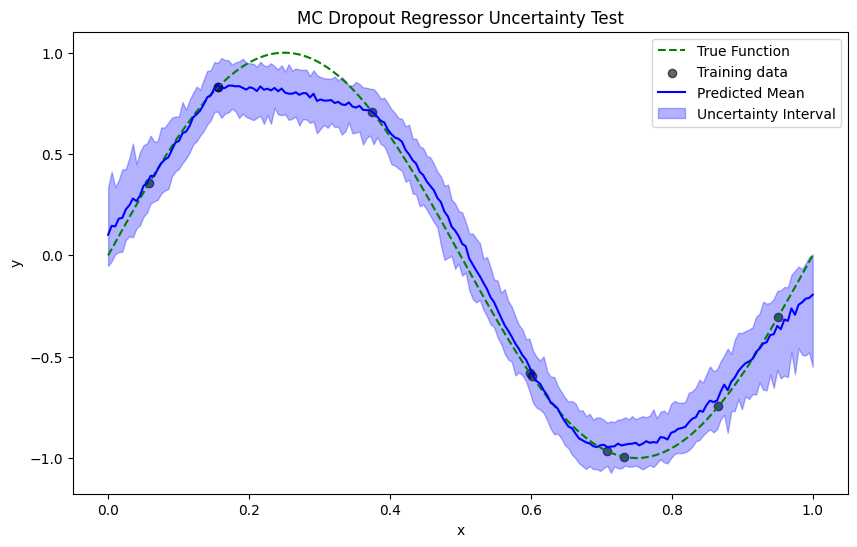

In [3]:
from uqregressors.bayesian.dropout import MCDropoutRegressor

dropout = MCDropoutRegressor(
    hidden_sizes=[100, 100],
    dropout=0.1,
    alpha=0.1,  # 90% confidence
    n_samples=100,
    epochs=1000,
    learning_rate=1e-3,
    device="cpu",  # use "cuda" if GPU available
    use_wandb=False
)

dropout.fit(X_train, y_train)
dropout_sol = dropout.predict(X_test)

plot_uncertainty_results(*dropout_sol, "MC Dropout Regressor")

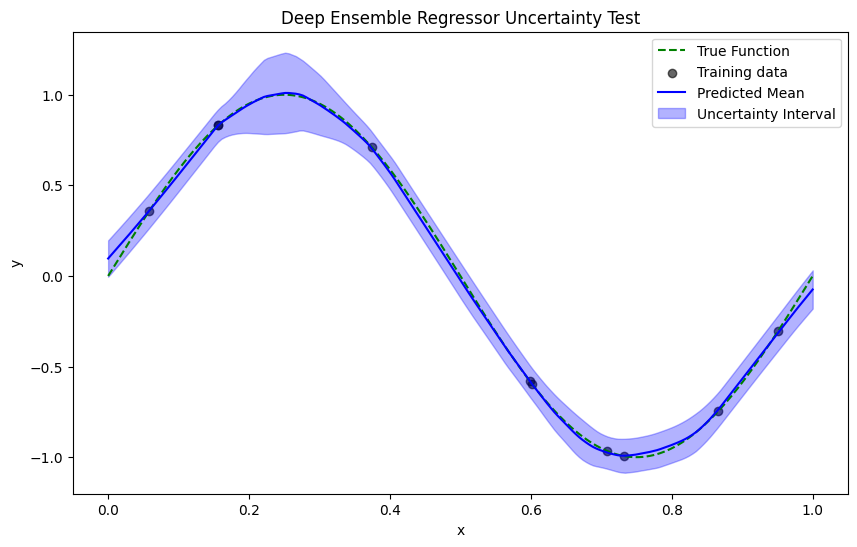

In [4]:
from uqregressors.bayesian.deep_ens import DeepEnsembleRegressor

deep_ens = DeepEnsembleRegressor(n_estimators=5, 
    hidden_sizes=[100, 100],
    alpha=0.1,  # 90% confidence
    epochs=1000,
    learning_rate=1e-3,
    device="cpu",  # use "cuda" if GPU available
    n_jobs=5,
    use_wandb=False)

deep_ens.fit(X_train, y_train)
deep_ens_sol = deep_ens.predict(X_test)

plot_uncertainty_results(*deep_ens_sol, "Deep Ensemble Regressor")

## Standard Gaussian Process Regression (GPR)

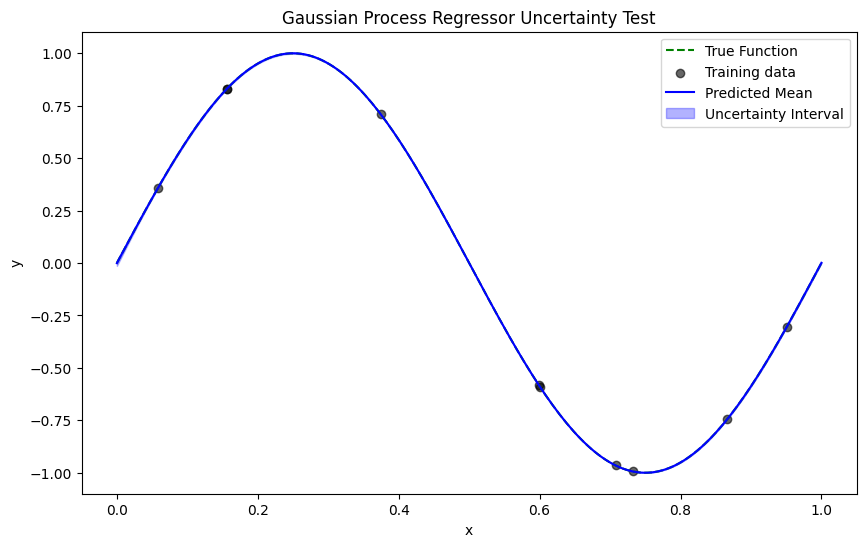

In [3]:
from uqregressors.bayesian.gaussian_process import GPRegressor
from sklearn.gaussian_process.kernels import RBF

gp_kwargs = {"normalize_y": True}
gpr = GPRegressor(kernel= RBF(length_scale=0.2, length_scale_bounds=(0.05, 1)), alpha=0.1, gp_kwargs=gp_kwargs)
gpr.fit(X_train, y_train)
gp_sol = gpr.predict(X_test)
plot_uncertainty_results(*gp_sol, "Gaussian Process Regressor")

## BBMM Gaussian Process

[Logger-24060] epoch=0, train_loss=1.105261206626892
[Logger-24060] epoch=50, train_loss=-0.14070597290992737
[Logger-24060] epoch=100, train_loss=-0.8268917798995972
[Logger-24060] epoch=150, train_loss=-0.931586742401123
[Logger-24060] epoch=200, train_loss=-0.945149302482605
[Logger-24060] epoch=250, train_loss=-0.9501996040344238
[Logger-24060] epoch=300, train_loss=-0.9527400135993958
[Logger-24060] epoch=350, train_loss=-0.9539862871170044
[Logger-24060] epoch=400, train_loss=-0.9553543925285339
[Logger-24060] epoch=450, train_loss=-0.9556704759597778
[Logger-24060] epoch=500, train_loss=-0.9563864469528198
[Logger-24060] epoch=550, train_loss=-0.9565121531486511
[Logger-24060] epoch=600, train_loss=-0.9568888545036316
[Logger-24060] epoch=650, train_loss=-0.9573601484298706
[Logger-24060] epoch=700, train_loss=-0.9571955800056458
[Logger-24060] epoch=750, train_loss=-0.9580046534538269
[Logger-24060] epoch=800, train_loss=-0.9578417539596558
[Logger-24060] epoch=850, train_loss=

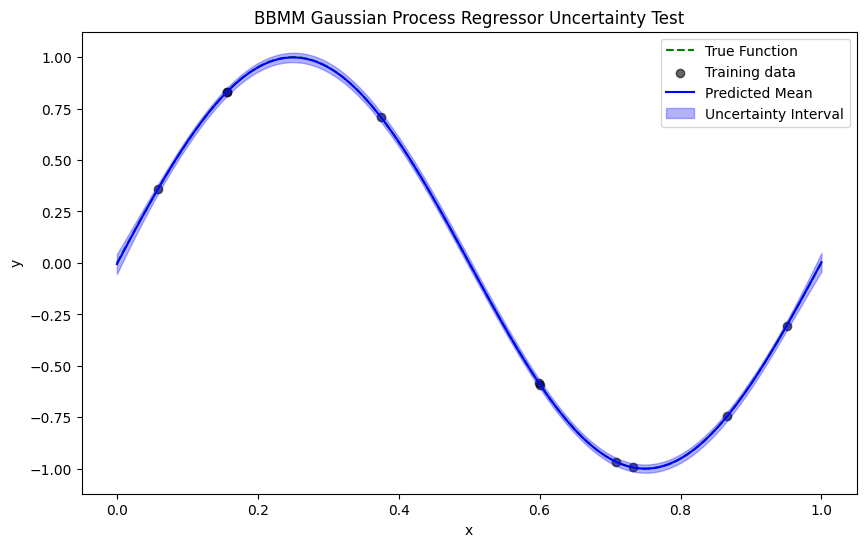

In [7]:
from uqregressors.bayesian.gaussian_process_torch import GPRegressorTorch
import gpytorch

bbmm_gp = GPRegressorTorch(kernel=gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()), 
                           likelihood=gpytorch.likelihoods.GaussianLikelihood(), 
                           alpha = 0.1,
                           epochs=1000,
                           learning_rate=1e-1,
                           device="cpu",
                           use_wandb=False)

bbmm_gp.fit(X_train, y_train)
bbmm_gp_sol = bbmm_gp.predict(X_test)
plot_uncertainty_results(*bbmm_gp_sol, "BBMM Gaussian Process Regressor")

## K-fold Conformal Quantile Regression 

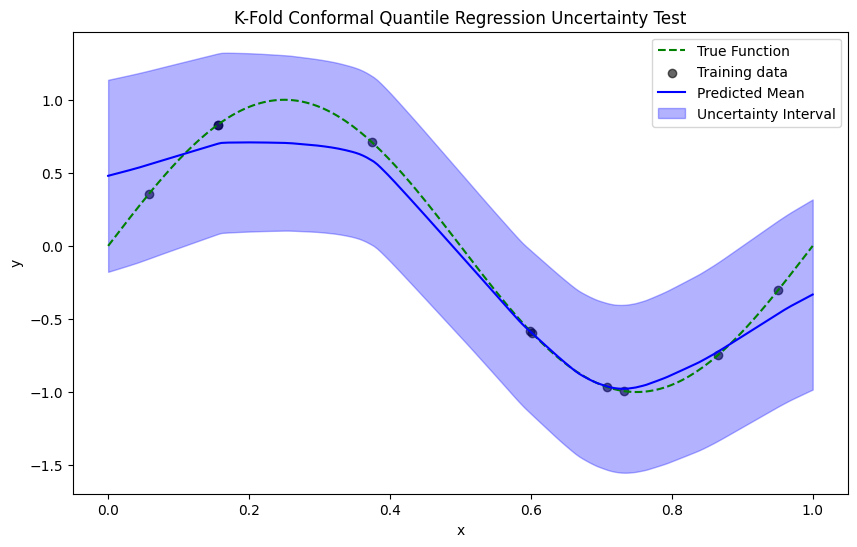

In [17]:
from uqregressors.conformal.k_fold_cqr import KFoldCQR
    
k_fold_cqr = KFoldCQR(n_estimators=5, 
    hidden_sizes=[100, 100],
    alpha=0.1,  # 90% confidence
    epochs=2500,
    learning_rate=1e-3,
    device="cpu",  # use "cuda" if GPU available
    n_jobs=5,
    use_wandb=False)

k_fold_cqr.fit(X_train, y_train)
k_fold_cqr_sol = k_fold_cqr.predict(X_test)

plot_uncertainty_results(*k_fold_cqr_sol, "K-Fold Conformal Quantile Regression")

## Normalized ConformalEns

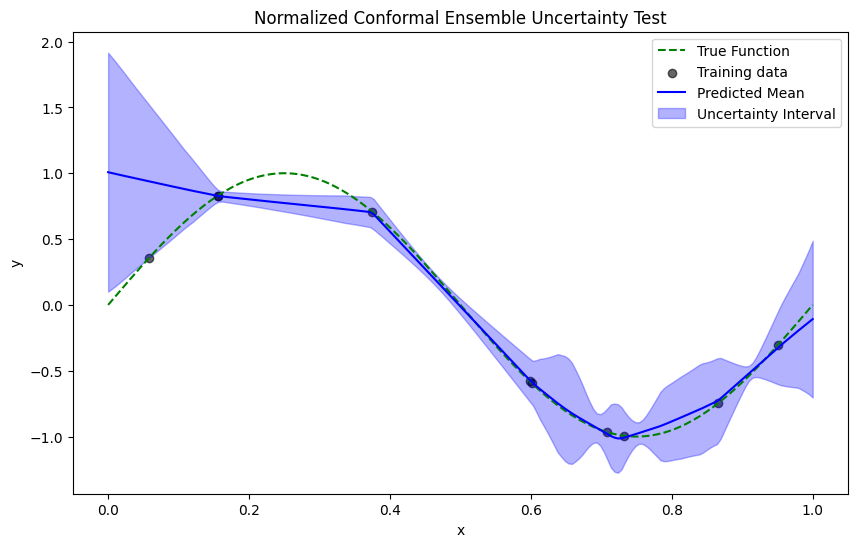

In [15]:
from uqregressors.conformal.conformal_ens import ConformalEnsRegressor

conformal_ens = ConformalEnsRegressor(n_estimators=5, 
    hidden_sizes=[100, 100],
    alpha=0.1,  # 90% confidence
    cal_size=0.2,
    epochs=1000,
    learning_rate=1e-3,
    device="cpu",  # use "cuda" if GPU available
    n_jobs=5,
    use_wandb=False)

conformal_ens.fit(X_train, y_train)
conformal_ens_sol = conformal_ens.predict(X_test)

plot_uncertainty_results(*conformal_ens_sol, "Normalized Conformal Ensemble")

## Normalized ConformalGauss

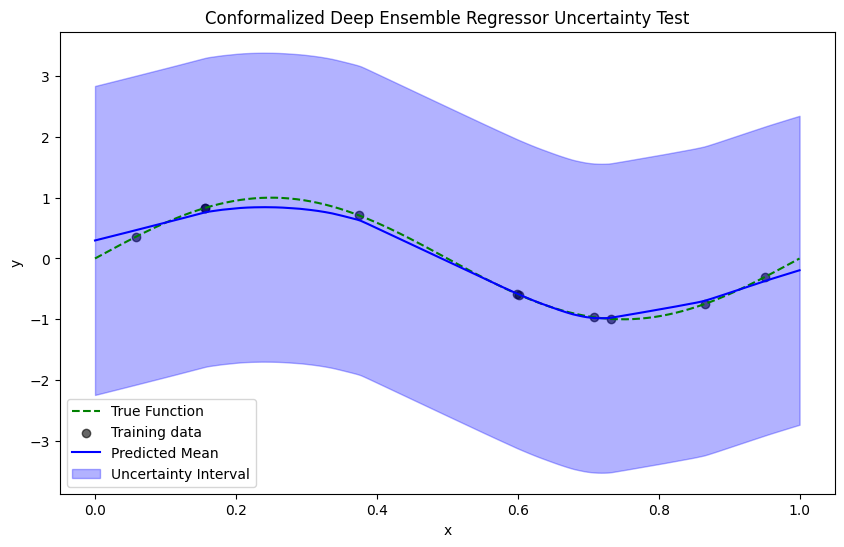

In [5]:
from uqregressors.conformal.conformal_deep_ens import ConformalizedDeepEns

conf_deep_ens = ConformalizedDeepEns(n_estimators=5, 
    hidden_sizes=[100, 100],
    alpha=0.1,  # 90% confidence
    epochs=1000,
    learning_rate=1e-3,
    device="cpu",  # use "cuda" if GPU available
    n_jobs=5,
    use_wandb=False)

conf_deep_ens.fit(X_train, y_train)
conf_deep_ens_sol = conf_deep_ens.predict(X_test)

plot_uncertainty_results(*conf_deep_ens_sol, "Conformalized Deep Ensemble Regressor")